# Pytorch Sandbox

In [1]:
# Installing libraries
pip install torchinfo

Note: you may need to restart the kernel to use updated packages.


In [1]:
# General libraries
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os

# Pytorch Model and training necessities
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchinfo import summary # For model architecture summary

# Model performance evaluation
from sklearn.metrics import precision_score, recall_score, f1_score

# Pytorch tensorboard support
from torch.utils.tensorboard import SummaryWriter

In [2]:
# Checking the availability of GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [4]:
# Define the CNN architecture
class FashionCNN(nn.Module):
    def __init__(self):
        # Calling nn.Module init method
        super(FashionCNN, self).__init__() # Similar to super().___init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2) 
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=1)
        # The input shape of the linear layer below correspond to the number of pixels
        # after the input has been flattened, which is output channel of previous channel * height * width.
        self.fc1 = nn.Linear(16 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.conv2(out)
        out = self.relu(out)
        out = self.maxpool(out)
        out = out.view(-1, 16*5*5) # Equivalent to flat layers (Reshape tensor). -1 let pytorch infer the second dimension
        out = self.fc1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [5]:
# Initialize the model, loss function, and optimizer
model = FashionCNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
summary(model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
FashionCNN                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 26, 26]            156
├─ReLU: 1-2                              [1, 6, 26, 26]            --
├─MaxPool2d: 1-3                         [1, 6, 13, 13]            --
├─Conv2d: 1-4                            [1, 16, 11, 11]           2,416
├─ReLU: 1-5                              [1, 16, 11, 11]           --
├─MaxPool2d: 1-6                         [1, 16, 5, 5]             --
├─Linear: 1-7                            [1, 128]                  51,328
├─ReLU: 1-8                              [1, 128]                  --
├─Linear: 1-9                            [1, 84]                   10,836
├─ReLU: 1-10                             [1, 84]                   --
├─Linear: 1-11                           [1, 10]                   850
Total params: 65,586
Trainable params: 65,586
Non-trainable params: 0
To

In [6]:
# Transformations to be applied to each image
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

# Load the Fashion-MNIST dataset (download the dataset if it's not already available)
root = os.path.join(os.getcwd(),"dataset")
train_dataset = datasets.FashionMNIST(
    root=root, 
    train=True, 
    download=True, 
    transform=transform
)

test_dataset = datasets.FashionMNIST(
    root=root, 
    train=False, 
    download=True, 
    transform=transform
)


In [7]:
# Create data loaders to load dataset in batch.
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=4, 
    shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=4, 
    shuffle=False
)

# Class labels
classes = (
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle Boot'
)

# Display split sizes
print("Training size: {}".format(len(train_dataset)))
print("Validation size: {}".format(len(test_dataset)))

Training size: 60000
Validation size: 10000


Image shape:  torch.Size([4, 1, 28, 28])
Pullover Ankle Boot T-shirt/top Coat


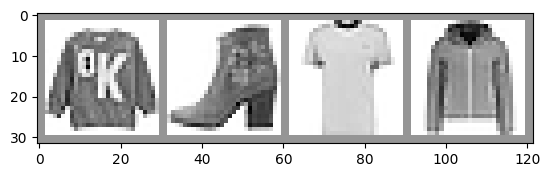

In [8]:
# Sanity check (Visualizing the first batch of images & labels)
def matplotlib_imshow(img, one_channel=False):
  if one_channel:
    img = img.mean(dim=0)
  img = img / 2 + 0.5
  npimg = img.numpy()
  if one_channel:
    plt.imshow(npimg, cmap="Greys")
  else:
    plt.imshow(np.transpose(npimg, (1,2,0)))

# The dataloader implement the iter protocol (iter magic method),
# thus to access data within it (batches of image & label)
# we must create an iterator object from it.
dataiter = iter(train_loader)
# Getting the first batch of images & labels (32 pairs)
images, labels = next(dataiter)

# Create a grid from the images and show them
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('Image shape: ', images.shape)
print(' '.join(classes[labels[j]] for j in range(len(labels))))

In [9]:
# Writing sample images to tensorboard
# Instantiating a SummaryWriter object. Signature: SummaryWriter('dir/tag'), the default dir is ./runs/.
writer = SummaryWriter('runs/fashion_mnist')
# Adding the image grid
writer.add_image('Four FashionMNIST images 2', img_grid)
# Write all pending events to disk
writer.flush()

In [11]:
# Training function
def train_one_epoch(epoch_index, tb_writer):
  running_loss = 0.
  last_loss = 0.

  # Looping each batch of data
  for i, (inputs, labels) in enumerate(train_loader):
    # Every data instance is a batch of image & label pairs.
    inputs, labels = inputs.to(device), labels.to(device)
    # Setting the gradient to zero for every batch (Mini-batch gradient descent)
    optimizer.zero_grad()
    # Compute the predictions for this batch (The forward method is called implicitly)
    outputs = model(inputs)
    # Compute the loss 
    loss = loss_fn(outputs, labels)
    # Compute the gradients using autograd
    loss.backward()
    # Adjusting the learning weights (Backprop)
    optimizer.step()
    # Logging the loss for each 1k batches.
    # For the current config (4 batches), there will be 15k batches in 1 epoch.
    running_loss += loss.item()
    if i % 1000 == 999:
      last_loss = running_loss / 1000
      print(f'Batch {i+1} loss: {last_loss}')
      # Visualizing with tensorboard
      tb_x = epoch_index * len(train_loader) + i + 1
      tb_writer.add_scalar('Loss/train', last_loss, tb_x)
      running_loss = 0.

  return last_loss

In [12]:
# Training loop
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0
EPOCHS = 7
best_vloss = 1_000_000. # vloss -> validation loss. Initial validation loss threshold.
for epoch in range(EPOCHS):
  print('\nEPOCH {}:'.format(epoch_number + 1))
  # Set the model to training mode
  model.train(True)
  # Calling the training function
  avg_loss = train_one_epoch(epoch_number, writer)
  running_vloss = 0.0
  # Set the model to evaluation mode
  model.eval()
  # Temporarily disable gradient computation during inference for validation data.
  with torch.no_grad():
    for i, (vinputs, vlabels) in enumerate(test_loader):
      vinputs, vlabels = vinputs.to(device), vlabels.to(device)
      voutputs = model(vinputs)
      vloss = loss_fn(voutputs, vlabels)
      running_vloss += vloss

  avg_vloss = running_vloss / (i + 1) # i + 1 because index starts from 0.
  print('Training loss: {}, validation loss: {}'.format(avg_loss, avg_vloss))

  # Log the average running loss for training & validation dataset to TensorBoard (at each batch)
  writer.add_scalars(
      main_tag='Training vs. Validation Loss',
      tag_scalar_dict={'Training': avg_loss, 'Validation': avg_vloss},
      global_step=epoch_number + 1
  )
  writer.flush()

  # Saved the model state that has the smallest validation loss (savepoint).
  if avg_vloss < best_vloss:
    best_vloss = avg_vloss
    model_path = 'model_{}_{}'.format(timestamp, epoch_number)
    torch.save(model.state_dict(), model_path)

  epoch_number += 1


EPOCH 1:
Batch 1000 loss: 1.6935092932879925
Batch 2000 loss: 0.7964923129491508
Batch 3000 loss: 0.6843814545702189
Batch 4000 loss: 0.5934257045909762
Batch 5000 loss: 0.5754465280887671
Batch 6000 loss: 0.5208729945053346
Batch 7000 loss: 0.4812990891374648
Batch 8000 loss: 0.47404948402300945
Batch 9000 loss: 0.4753556819287478
Batch 10000 loss: 0.45554060108569683
Batch 11000 loss: 0.4420226871923078
Batch 12000 loss: 0.4057664921041869
Batch 13000 loss: 0.41184616823491527
Batch 14000 loss: 0.3945435380007184
Batch 15000 loss: 0.3815532859823434
Training loss: 0.3815532859823434, validation loss: 0.406253457069397

EPOCH 2:
Batch 1000 loss: 0.37927764279543774
Batch 2000 loss: 0.3902988552075403
Batch 3000 loss: 0.37117619880595887
Batch 4000 loss: 0.3661907038381032
Batch 5000 loss: 0.3902758456920128
Batch 6000 loss: 0.3439492403399199
Batch 7000 loss: 0.34273655101879924
Batch 8000 loss: 0.3425112566638272
Batch 9000 loss: 0.33756579473233433
Batch 10000 loss: 0.3470450039299

In [6]:
# Load pre-trained weights
model.load_state_dict(torch.load('/kaggle/input/variant_1/pytorch/test-1/1/model_20240325_185715_2'))

<All keys matched successfully>

In [13]:
# Calculating multiclassification metrics & confusion matrix
model.eval()
with torch.no_grad():
    for vinputs, vlabels in test_loader:
        vinputs, vlabels = vinputs.to(device), vlabels.to(device)
        voutputs = model(vinputs)
        # Sending back the outputs & label to CPU
        voutputs = voutputs.detach().cpu().numpy()
        vlabels = vlabels.detach().cpu().numpy()
    
precision = precision_score(vlabels, voutputs.argmax(axis=1), average='macro')
recall = recall_score(vlabels, voutputs.argmax(axis=1), average='macro')
f1 = f1_score(vlabels, voutputs.argmax(axis=1), average='macro')

print('Precission: ', precision)
print('Recall: ', recall)
print('F1_Macro: ', f1)

Precission:  1.0
Recall:  1.0
F1_Macro:  1.0


In [14]:
# Final save for model & weights
torch.save(model.state_dict(), 'final_weights.pth')

# Multimodal Model Experiment